In [282]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [314]:
def update_canvass(v):
    """update numpy matrix given world.
    """
    v[:] = 0
    for i in range(N_ROWS):
        for j in range(N_COLS):
            loc = (i, j)
            if loc in WORLD.keys():
                v[i][j] = WORLD[loc][0]
    return v

def _draw(prob):
    return np.random.uniform() > (1 - prob)

def _summarize(w):
    count = {}
    for i, j in w.values():
        if i not in count.keys():
            count[i] = 1
        else:
            count[i] += 1
    print(count)    
    
def take_first(elem):
    return elem[0]


def _return_random_loc():
    i = random.choice(np.arange(N_ROWS))
    j = random.choice(np.arange(N_COLS))
    return (i, j)

In [284]:
def _seek(loc):
    """returns a randomly selected valid move from loc.
    
    a loc is valid if it's in the board and an unoccupied slot.
    """
    i = loc[0]
    j = loc[1]
    
    # step 1 - make sure it's on the board
    new_locs = [(min(i + 1, N_ROWS - 1), j), 
                (max(i - 1, 0), j), 
                (i, min(j + 1, N_COLS - 1)), 
                (i, max(j - 1, 0))]
    
    # step 2 - make sure the next loc is not occupied
    new_locs = [loc for loc in new_locs if loc not in WORLD.keys()]
    
    # step 3 - if there are no unoccupied slots, then stay put
    if new_locs:
        return random.choice(new_locs)
    return loc

            
def _move(curr_loc, next_loc, element):
    """move element from curr_loc to next_loc.
    """
    if next_loc != curr_loc:
        WORLD[next_loc] = element
        WORLD.pop(curr_loc)
        return True
    return False

def _return_neighboring_locs(curr_loc, dist):
    """return neighboring locs, occupied or unoccupied
    """
    i = curr_loc[0]
    j = curr_loc[1]
    neighboring_locs = [(min(i + dist, N_ROWS - dist), j), 
                        (max(i - dist, 0), j), 
                        (i, min(j + dist, N_COLS - dist)), 
                        (i, max(j - dist, 0))]
    # check that neighbor is not itself
    neighboring_locs = [loc for loc in neighboring_locs if loc != curr_loc]
    
    return neighboring_locs

def _sample():
    return np.random.randint(0, 100)

def _return_neighboring_occupied_locs(curr_loc):
    """return all locs that are occupied.
    """
    neighboring_locs = _return_neighboring_locs(curr_loc, 1)
    return [loc for loc in neighboring_locs if loc in WORLD.keys()]

In [374]:
def update_dreg(curr_loc):
    
    # do something to a neighbor slot
    next_loc = _seek(curr_loc)
    
    if _draw(.30):  # create res with 30% chance
        WORLD[next_loc] = (2, None)
    elif _draw(.01):  # or create a new dreg with 1% chance
        WORLD[next_loc] = (1, None)
    else:
        pass
    
    # if dreg is next to a occupied slot, randomly destroy neighborhood
    if _draw(.01):
        neighbors = _return_neighboring_occupied_locs(curr_loc)
        # print("curr is ", curr_loc, "with neighbors", neighbors)
        if neighbors:
            for loc in neighbors:
                # print("popping", loc)
                WORLD.pop(loc)

    # move to an unoccupied slot (or stay put if there are no unoccupied slots)
    e = (1, None)
    next_loc = _seek(curr_loc)
    # print("curr loc is", curr_loc, curr_loc in WORLD.keys())
    _ = _move(curr_loc, next_loc, e)

    
def update_res(curr_loc):
    
    if np.random.uniform() < .3:
        WORLD.pop(curr_loc)
    else:
        # move res to an unoccupied slot (or stay put if there are no unoccupied slots)
        e = (2, None)
        next_loc = _seek(curr_loc)
        _ = _move(curr_loc, next_loc, e)
        

def update_data(curr_loc):
    if _draw(.20):
        e = (4, WORLD[curr_loc][1])
        next_loc = _seek(curr_loc)
        _ = _move(curr_loc, next_loc, e)
    

def update_emitter(curr_loc):
    """
    emitter has an id of 5
    
    1) emit data in a neighboring free spot 
    2) then reproduce itself if there is a res, 
    3) no moving so it stays where it was created.
    """

    # step 1 - if a neighbor is a res... turn it into data
    
    neighboring_locs = _return_neighboring_occupied_locs(curr_loc)
    if neighboring_locs:
        for neighbor in neighboring_locs:
            if WORLD[neighbor][0] == 2:
                WORLD[neighbor] = (4, _sample())
                                
                
def update_sorter(curr_loc):
    """
    In  this  version, Sorter has two primary functions. 
    
    First, whenever it sees a Res, it transmutes it into another Sorter, and so 
    the Sorterpopulation  level  is indirectly  controlled  byDReg.
    
    Secondly,Sorter transports Datums from right to left when possible, and also up 
    or down based on the comparison of the Datum’svalue with a 32-bitthresholdstored 
    in theSorter. 
    
    When aDatum‘crosses’ theSorterduring  a  move,  theSortercopies  theDatum’s  value  to  its  threshold
    """
    right_loc = (curr_loc[0], curr_loc[1] + 1)
    
    # step 1 - move data... if theres something to its right
    if right_loc in WORLD.keys():
        neighbor = WORLD[right_loc]
        
        # we only want data elements...
        if neighbor[0] == 4:
                dist = 2
            # move it if data is greater
            if neighbor[1] > WORLD[curr_loc][1]:
                
                # move data up and the left

                next_loc = (curr_loc[0] - dist, curr_loc[1] - dist)
                WORLD[next_loc] = (4, neighbor[1])
                WORLD.pop(right_loc)
                
                # sorter update its internal value
                WORLD[curr_loc] = (3, neighbor[1])
            
            # if not... move data down left
            else:
                next_loc = (curr_loc[0] + dist, curr_loc[1] - dist)
                WORLD[next_loc] = (4, neighbor[1])
                WORLD.pop(right_loc)

                
                
    # step 2 - if there is a neighboring res... turn it into a sorter
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 2:
                WORLD[neighbor] = (3, _sample())
    
    
    # step 3 - move if one of its neighbors is a sorter
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 3:
                next_loc = _seek(curr_loc)
                e = (3, WORLD[curr_loc][1])
                _ = _move(curr_loc, next_loc, e)
                break
                
    # step 4 - die if it's surrounded by too many sorters
    count = 0
    neighbors = _return_neighboring_occupied_locs(curr_loc)
    if neighbors:
        for neighbor in neighbors:
            if WORLD[neighbor][0] == 3:
                count += 1
    if count > 3:
        WORLD.pop(next_loc)  # it is a next_loc because it moved in step 3

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 88)

In [ ]:
# create the world
def create_world():
    world = {}
    
    # create dregs
    for _ in range(5):
        loc = _return_random_loc()
        world[loc] = (1, None)
        
    # create sorter (represented by id 3)
    for _ in range(5):
        loc = _return_random_loc()
        world[loc] = (3, _sample())
        
    
    # create emitter (represented by 5)
    for _ in range(15):
        i = random.choice(np.arange(N_ROWS))
        j = random.choice(np.arange(N_COLS - 10, N_COLS))
        loc = (i, j)
        world[loc] = (5, None)
    return world

In [ ]:
N_ROWS = 30
N_COLS = 60
epochs = 500000

WORLD = create_world()
CANVASS = np.zeros((N_ROWS, N_COLS))

for epoch in range(epochs):        
    
    # select a random element to update
    loc = random.choice(list(WORLD.keys()))
    element = WORLD[loc]
    
    element_id = element[0]
    
    if element_id == 1:  # dreg
        update_dreg(loc)
    elif element_id == 2:  # res
        update_res(loc)
    elif element_id == 3:  # sorter
        update_sorter(loc)
    elif element_id == 4:  # data
        update_data(loc)
    elif element_id == 5:  # emitter
        update_emitter(loc)
    else:
        pass
    
    if epoch % (epochs / 50) == 0:
        CANVASS = update_canvass(CANVASS)
        plt.figure(figsize=(20,5))
        plt.imshow(CANVASS, cmap='jet')
        plt.colorbar(cmap='jet')

/Users/vincenttang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [376]:
_summarize(WORLD)

{5: 14, 3: 315, 4: 48, 1: 10, 2: 1}


In [377]:
# we want data elements on the left side of the board

keep = []
for k in WORLD.keys():
    if k[1] < 20 and WORLD[k][0] == 4:
        keep.append(k)
# keep

In [378]:
sorted_list = sorted(keep, key=take_first)

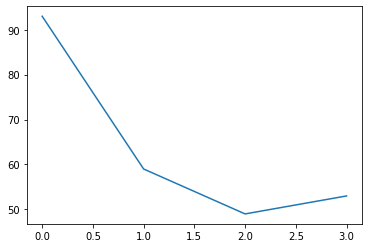

In [379]:
# shuld be descending order
ans = []
for i in sorted_list:
    ans.append(WORLD[i][1])
    
plt.plot(ans)